<a href="https://colab.research.google.com/github/edinaldoab/challenge_data_science_2/blob/main/notebooks/semana02_tratamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semana 2
### Contextualização


Aqui será empregado uma abordagem de **Ciências de Dados**! Toda a base tratada e disponibilizada no formato PARQUET será explorada e tratada para finalmente elencar e criar os modelos de Machine Learning.
<br>
<br>
**Recordando: Na primeira semana do desafio, todos os esforços foram dedicados ao tratamento da base de dados bruta disponibilizada pelos desafiadores.**

# 1. Preparação do Ambiente

## a. Instalação das dependências

In [1]:
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

## b. Inicialização da SparkSession

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("challenge_imob") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

## c. Montagem do Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## d. Inicializando a  UI do Spark 

In [6]:
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [7]:
with open('/content/drive/MyDrive/Colab Notebooks/projeto_data_science_imobni/dados/authTokenngrok.txt', 'r') as file:
  content = file.read()
  file.close()

my_authtoken = str(content)

In [8]:
get_ipython().system_raw('./ngrok authtoken ' + my_authtoken)
get_ipython().system_raw('./ngrok http 4050 &')

!curl -s http://localhost:4040/api/tunnels

{"tunnels":[],"uri":"/api/tunnels"}


In [9]:
spark

Carregamento dos dados:

# 2. Carregamento e tratamento dos dados

## a. Leitura do dataset

In [104]:
path='/content/drive/MyDrive/Colab Notebooks/projeto_data_science_imobni/dataset_parquet'

data = spark.read.parquet(path)

In [105]:
data.show(5)

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+---------------+----------+----------+-----+-----+-------+
|                  id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|         bairro|      zona|condominio| iptu| tipo|  valor|
+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+---------------+----------+----------+-----+-----+-------+
|00790b85-56e3-43a...|   11|       166|      166|        5|[Academia, Churra...|      4|     4|       Usado| Apartamento|Residencial|   2|    Jacarepaguá|Zona Oeste|      2100| 4600|Venda|1750000|
|007f8099-8e1d-45f...|    4|       640|      640|        5|[Animais permitid...|     11|     3|       Usado| Apartamento|Residencial|null|           Urca|  Zona Sul|      3060|20030|Venda|3800000|
|00b23c6d-0e9d-

## b. Seleção de features

Aqui devem ser removidas as colunas que possuem apenas um valor atribuído, de acordo com o que foi elaborado na primeira semana. Esta etapa é muito importante para se reduzir a complexidade dos dados e aumentar a velocidade de ajuste do modelo.

In [106]:
data\
    .select('tipo')\
    .distinct()\
    .show(5)

+-----+
| tipo|
+-----+
|Venda|
+-----+



In [107]:
data\
    .select('tipo_anuncio')\
    .distinct()\
    .show(5)

+------------+
|tipo_anuncio|
+------------+
|       Usado|
+------------+



In [108]:
data\
    .select('tipo_unidade')\
    .distinct()\
    .show(5)

+------------+
|tipo_unidade|
+------------+
| Apartamento|
+------------+



In [109]:
data\
    .select('tipo_uso')\
    .distinct()\
    .show(5)

+-----------+
|   tipo_uso|
+-----------+
|Residencial|
+-----------+



As colunas `area_total` e `area_util` têm um potencial maior de aderência ao modelo. Assim, analisa-se:

In [110]:
data\
    .select('area_total','area_util')\
    .show(5)

+----------+---------+
|area_total|area_util|
+----------+---------+
|       166|      166|
|       640|      640|
|        50|       50|
|       160|      160|
|        52|       52|
+----------+---------+
only showing top 5 rows



In [111]:
data\
    .select('area_util', 'area_total')\
    .na\
    .drop()\
    .show(5)

+---------+----------+
|area_util|area_total|
+---------+----------+
|      166|       166|
|      640|       640|
|       50|        50|
|      160|       160|
|       52|        52|
+---------+----------+
only showing top 5 rows



In [112]:
from pyspark.sql import functions as f

dados_without_na = data\
    .select('area_util', 'area_total')\
    .na\
    .drop()

quantidade_total = dados_without_na.count()
quantidade_iguais = dados_without_na.filter(f.col('area_util') == f.col('area_total')).count()
quantidade_distintas = quantidade_total - quantidade_iguais

print(f'Quantidade de linhas: {quantidade_total}')
print(f'Quantidade de linhas com area_util == area_total: {quantidade_iguais}')
print(f'Quantidade de linhas diferentes: {quantidade_distintas}')

Quantidade de linhas: 57368
Quantidade de linhas com area_util == area_total: 55384
Quantidade de linhas diferentes: 1984


Chega-se a algumas conclusões:
<br>
<br>
*  das 57368 linhas, 55384 possuem valores iguais nas colunas `area_total` e `area_util`
*  pode-se escolher somente uma, uma vez que a maioria das informações são repetidas

Para esta escolha, levou-se em conta a coluna com a menor quantidade de dados nulos:

In [113]:
colunas = ['area_total', 'area_util']

data\
    .select([f.count(f.when(data[c].isNull(), True)).alias(c) for c in colunas])\
    .show()

+----------+---------+
|area_total|area_util|
+----------+---------+
|      9194|        0|
+----------+---------+



In [114]:
# cont = []
# for c in colunas:
#     cont.append(f.count(f.when(data[c].isNull(), True)).alias(c))

# data.select(cont).show()

A `area_total` não possui nenhum valor nulo! Pode-se então eliminar a coluna `area_util`.

In [115]:
data = data\
    .drop('area_total','tipo_anuncio','tipo_unidade','tipo_uso','tipo')

In [116]:
data.show(5)

+--------------------+-----+---------+---------+--------------------+-------+------+----+---------------+----------+----------+-----+-------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|         bairro|      zona|condominio| iptu|  valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+---------------+----------+----------+-----+-------+
|00790b85-56e3-43a...|   11|      166|        5|[Academia, Churra...|      4|     4|   2|    Jacarepaguá|Zona Oeste|      2100| 4600|1750000|
|007f8099-8e1d-45f...|    4|      640|        5|[Animais permitid...|     11|     3|null|           Urca|  Zona Sul|      3060|20030|3800000|
|00b23c6d-0e9d-4be...|    1|       50|        1|[Academia, Churra...|      2|     0|   1|Parada de Lucas|Zona Norte|       363|   97| 192000|
|012aebd7-278f-4b4...|    0|      160|        4|          [Elevador]|      3|     1|   3|        Ipanema|  Zona Sul|      1530| 7440|3490000|
|0267d

## c. Conversão dos tipos das colunas

In [117]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- valor: string (nullable = true)



Os dados numéricos estão tipados em sua maioria como string, enquanto deveriam receber as seguintes conversões:



In [118]:
from pyspark.sql.types import IntegerType, DoubleType

In [119]:
data = data\
    .withColumn('andar', data['andar'].cast(IntegerType()))\
    .withColumn('area_util', data['area_util'].cast(DoubleType()))\
    .withColumn('banheiros', data['banheiros'].cast(IntegerType()))\
    .withColumn('quartos', data['quartos'].cast(IntegerType()))\
    .withColumn('suites', data['suites'].cast(IntegerType()))\
    .withColumn('condominio', data['condominio'].cast(DoubleType()))\
    .withColumn('vaga', data['vaga'].cast(IntegerType()))\
    .withColumn('iptu', data['iptu'].cast(DoubleType()))\
    .withColumn('valor', data['valor'].cast(DoubleType()))

In [120]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)



## d. Tratamento da coluna `caracteristicas`

In [121]:
data\
    .select('caracteristicas')\
    .show(100, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------+
|caracteristicas                                                                                                                                   |
+--------------------------------------------------------------------------------------------------------------------------------------------------+
|[Academia, Churrasqueira, Piscina, Playground, Salão de festas, Elevador, Condomínio fechado, Portão eletrônico, Portaria 24h, Animais permitidos]|
|[Animais permitidos, Portão eletrônico]                                                                                                           |
|[Academia, Churrasqueira, Piscina, Playground, Salão de festas, Condomínio fechado, Portaria 24h, Animais permitidos]                             |
|[Elevador]                                                                                               

A consulta da coluna característica mostra que algumas listas atribuídas estão vazias. A tratativa para este caso, é convertê-las para `null`:

In [122]:
data = data.withColumn('caracteristicas', f.when((f.size(f.col('caracteristicas')) == 0), f.lit(None)).otherwise(f.col('caracteristicas')))

In [123]:
data.show()

+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+----------+----------+-------+---------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|              bairro|      zona|condominio|   iptu|    valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+----------+----------+-------+---------+
|00790b85-56e3-43a...|   11|    166.0|        5|[Academia, Churra...|      4|     4|   2|         Jacarepaguá|Zona Oeste|    2100.0| 4600.0|1750000.0|
|007f8099-8e1d-45f...|    4|    640.0|        5|[Animais permitid...|     11|     3|null|                Urca|  Zona Sul|    3060.0|20030.0|3800000.0|
|00b23c6d-0e9d-4be...|    1|     50.0|        1|[Academia, Churra...|      2|     0|   1|     Parada de Lucas|Zona Norte|     363.0|   97.0| 192000.0|
|012aebd7-278f-4b4...|    0|    160.0|        4|          [Elevador]|      3|     1|   3|     

## e. Tratamento dos dados faltantes

Como os modelos de ML não lidam bem com dados faltantes, analisa-se onde e o quanto eles estão alocados nas colunas:

In [124]:
data\
    .select([f.count(f.when(data[c].isNull(), True)).alias(c) for c in data.columns])\
    .show()

+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
| id|andar|area_util|banheiros|caracteristicas|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|  0|    0|        0|        0|          12736|      0|  5554|3017|     0|   0|      2371|7199|    0|
+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+



In [125]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)



Para os dados numéricos, trocam-se os valores nulos pelo número zero:

In [126]:
data = data\
    .select('*')\
    .na\
    .fill(0)

In [127]:
data.show()

+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+----------+----------+-------+---------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|              bairro|      zona|condominio|   iptu|    valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+----------+----------+-------+---------+
|00790b85-56e3-43a...|   11|    166.0|        5|[Academia, Churra...|      4|     4|   2|         Jacarepaguá|Zona Oeste|    2100.0| 4600.0|1750000.0|
|007f8099-8e1d-45f...|    4|    640.0|        5|[Animais permitid...|     11|     3|   0|                Urca|  Zona Sul|    3060.0|20030.0|3800000.0|
|00b23c6d-0e9d-4be...|    1|     50.0|        1|[Academia, Churra...|      2|     0|   1|     Parada de Lucas|Zona Norte|     363.0|   97.0| 192000.0|
|012aebd7-278f-4b4...|    0|    160.0|        4|          [Elevador]|      3|     1|   3|     

Em seguida, analisa-se a coluna não numérica `zona`:

In [128]:
data\
    .select('zona')\
    .groupBy('zona')\
    .count()\
    .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11897|
|  Zona Oeste|32979|
|Zona Central| 1144|
|    Zona Sul|20531|
|            |   11|
+------------+-----+



Os 11 valores que possuem como zona uma string vazia, podem ser desconsiderados:

In [129]:
data = data.filter(f.col('zona') != '')

In [130]:
data\
    .select('zona')\
    .groupBy('zona')\
    .count()\
    .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11897|
|  Zona Oeste|32979|
|Zona Central| 1144|
|    Zona Sul|20531|
+------------+-----+



# Preparação dos dados para o modelo de ML

## a. Variáveis dummy

As variáveis categóricas serão transformadas em variáveis binárias. Isto é, se a variável tem uma categoria atribuída, ela receberá 1, caso o contrário, receberá 0.

Antes, deve-se desmembrar o conjunto `características` em outro dataset e o de `zona` também.

Desmembrando a coluna `caracteristicas` em outro dataset:

In [131]:
data\
    .select("*", f.explode("caracteristicas").alias("cara"))\
    .groupBy("id")\
    .pivot('cara')\
    .agg(f.lit(1))\
    .na\
    .fill(0)\
    .show(truncate=False)

+------------------------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|id                                  |Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+------------------------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|1bbc40f3-4f5c-4595-99b1-56ef42a54ede|1       |0                 |0            |1                 |1       |1      |1         |1           |1                |1              |
|afecddff-f4cc-4ab8-bdbf-242b7dff7241|1       |1                 |1            |1                 |1       |1      |1         |1           |1                |1              |
|bfffedfe-99e7-4aed-9a9f-f766225a0f1f|0       |1                 |1            |1                 |1       |0      |1        

In [132]:
caracteristicas = data\
    .select('*', f.explode('caracteristicas').alias('cara'))\
    .groupby('id')\
    .pivot('cara')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [133]:
caracteristicas.show(5)

+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|1bbc40f3-4f5c-459...|       1|                 0|            0|                 1|       1|      1|         1|           1|                1|              1|
|afecddff-f4cc-4ab...|       1|                 1|            1|                 1|       1|      1|         1|           1|                1|              1|
|bfffedfe-99e7-4ae...|       0|                 1|            1|                 1|       1|      0|         1|           0|                1|              1|
|fcb67af3-5601-415...|       1|               

In [134]:
zona = data\
    .groupby('id')\
    .pivot('zona')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [135]:
zona.show(5)

+--------------------+------------+----------+----------+--------+
|                  id|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|           0|         0|         0|       1|
|02fba6ef-a691-442...|           0|         0|         1|       0|
|3dd5d200-0a7f-43d...|           0|         0|         0|       1|
|82707939-71bd-40c...|           0|         0|         0|       1|
|fc03c1a9-8bbb-41a...|           0|         1|         0|       0|
+--------------------+------------+----------+----------+--------+
only showing top 5 rows



## b. Montando o conjunto de dados completo

In [136]:
cont_rows_original = data.count()

In [137]:
data = data\
    .join(zona, 'id', how='inner')\
    .join(caracteristicas, 'id', how='left')\
    .drop('zona','cara','caracteristicas')\
    .na\
    .fill(0)

Validando se os joins realizados não comprometerão a quantidade de linhas da base original:

In [138]:
print(f'#linhas antes: {cont_rows_original}')
print(f'#linhas depois: {data.count()}')
print(f'#linhas perdidas: {cont_rows_original - data.count()}')

#linhas antes: 66551
#linhas depois: 66551
#linhas perdidas: 0


In [139]:
data.show(5)

+--------------------+-----+---------+---------+-------+------+----+---------------+----------+-------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|         bairro|condominio|   iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+---------------+----------+-------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00790b85-56e3-43a...|   11|    166.0|        5|      4|     4|   2|    Jacarepaguá|    2100.0| 4600.0|1750000.0|     

In [140]:
data.filter(f.col('id')=="be269ddf-a4a3-4a72-bd54-93cdccf512dd").show(5)

+--------------------+-----+---------+---------+-------+------+----+------------+----------+----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio|iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|be269ddf-a4a3-4a7...|    0|     45.0|        1|      2|     0|   1|Campo Grande|     356.0| 0.0|140000.0|           0|         0|         

# Disponibilização do dataset em PARQUET

In [141]:
data = data\
    .withColumnRenamed('Zona Central','zona_central')\
    .withColumnRenamed('Zona Norte','zona_norte')\
    .withColumnRenamed('Zona Oeste','zona_oeste')\
    .withColumnRenamed('Zona Sul','zona_sul')\
    .withColumnRenamed('Animais Permitidos','animais_permitidos')\
    .withColumnRenamed('Portaria 24h','portaria_24h')\
    .withColumnRenamed('Salão de festas','salao_de_festas')\
    .withColumnRenamed('Condomínio fechado','condominio_fechado')\
    .withColumnRenamed('Portão eletrônico','portao_eletronico')

In [142]:
data\
    .write\
    .parquet('/content/drive/MyDrive/Colab Notebooks/projeto_data_science_imobni/dataset_ml_regressao', mode='overwrite')

# Extra

## a. Análise de correlação

Com o intuito de detectar a redundância entre as variáveis, realiza-se a análise da **correlação** entre as variáveis numéricas da base:

In [143]:
from pyspark.ml.stat import Correlation

In [144]:
lista_zona = ['zona_central','zona_norte','zona_oeste','zona_sul']

lista_caracteristicas = ['condominio_fechado',
                        'Playground',
                        'portao_eletronico',
                        'Piscina',
                        'animais_permitidos',
                        'portaria_24h',
                        'Elevador',
                        'Academia',
                        'salao_de_festas',
                        'Churrasqueira']

In [145]:
input_col_corr = [i for i in data.columns if i not in ['id', 'bairro'] + lista_zona + lista_caracteristicas]

print(input_col_corr)

['andar', 'area_util', 'banheiros', 'quartos', 'suites', 'vaga', 'condominio', 'iptu', 'valor']


In [146]:
from pyspark.ml.feature import VectorAssembler

In [147]:
assembler = VectorAssembler(inputCols=input_col_corr,outputCol='features')

In [148]:
df = assembler.transform(data).select('features')

In [149]:
correlacao = Correlation.corr(df, 'features','pearson').collect()[0][0]

In [150]:
rows = correlacao.toArray().tolist()
df = spark.createDataFrame(rows,input_col_corr)

df.show(5)

+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               andar|           area_util|          banheiros|            quartos|              suites|                vaga|          condominio|                iptu|               valor|
+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|0.020674885718290365|0.01757715331670837|0.01008345278433918|0.024274113790925932|0.018271843474796625|0.006617930248883...|3.810955786364057...|0.016145590401859373|
|0.020674885718290365|                 1.0| 0.6710305514514978| 0.6740755967299021|  0.6201287358480546|  0.4719284382321347|0.045676565706072016|0.021337139034350524|  0.7586357636188664|
| 0.01757715331670837|  0.6710305514514978|            

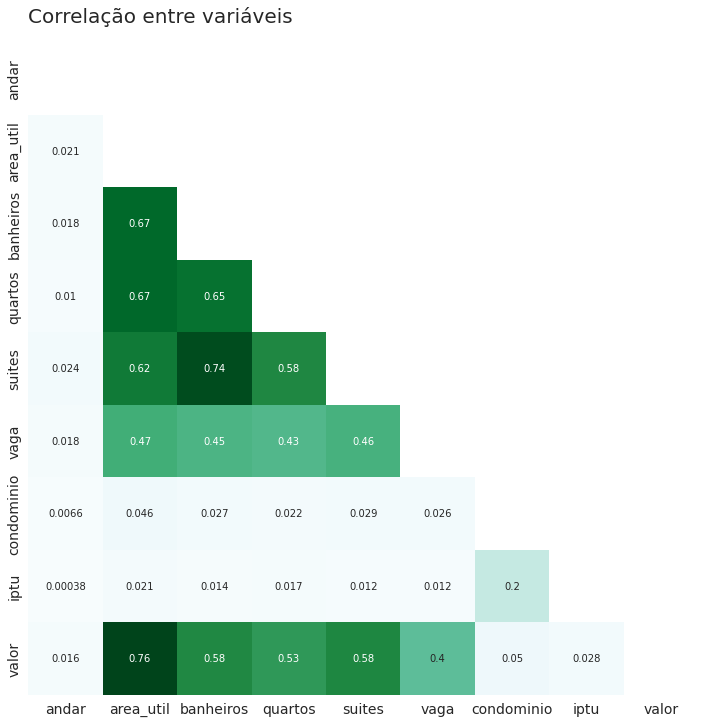

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.toPandas().set_index([input_col_corr])
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask, fmt=".2",  annot=True, cbar=False, cmap='BuGn')
    ax.tick_params(labelsize=14)
    ax.set_title('Correlação entre variáveis', fontsize=20, loc='left', pad=20)

O gráfico de correlação leva à conclusão de que o `valor` do apartamento tem uma correlação relativamento alta com as variáveis de `area_util` e `banheiros` quando comparada com o conjunto, porém não é tão forte. Sendo assim, nenhuma das variáveis serão descartadas.

## b. Vetorização dos dados

Para preparar os dados para o modelo de ML do PySpark, deve-se primeiro vetorizá-los a partir da chamada da função `VectorAssemble`.

In [152]:
from pyspark.ml.feature import VectorAssembler

In [153]:
data.withColumnRenamed('valor','label').show(5)

+--------------------+-----+---------+---------+-------+------+----+---------------+----------+-------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|         bairro|condominio|   iptu|    label|zona_central|zona_norte|zona_oeste|zona_sul|Academia|animais_permitidos|Churrasqueira|condominio_fechado|Elevador|Piscina|Playground|portaria_24h|portao_eletronico|salao_de_festas|
+--------------------+-----+---------+---------+-------+------+----+---------------+----------+-------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00790b85-56e3-43a...|   11|    166.0|        5|      4|     4|   2|    Jacarepaguá|    2100.0| 4600.0|1750000.0|     

In [154]:
data = data.withColumnRenamed('valor','label')

Todas as colunas serão utilizadas no modelo, exceto as colunas 
*  `label`: variável alvo,
*  `id`: identificador único e 
*  `bairro`: não foi transformada em variável dummy por possuir muitas atribuições

In [155]:
input_col = [i for i in data.columns if i not in ['label', 'id', 'bairro']]

In [156]:
assembler = VectorAssembler(inputCols=input_col, outputCol='features')

In [157]:
data_prep = assembler.transform(data).select('features','label')

In [158]:
data_prep.show(5, truncate=False)

+--------------------------------------------------------------------------------------------------+---------+
|features                                                                                          |label    |
+--------------------------------------------------------------------------------------------------+---------+
|[11.0,166.0,5.0,4.0,4.0,2.0,2100.0,4600.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]|1750000.0|
|(22,[0,1,2,3,4,6,7,11,13,20],[4.0,640.0,5.0,11.0,3.0,3060.0,20030.0,1.0,1.0,1.0])                 |3800000.0|
|[1.0,50.0,1.0,2.0,0.0,1.0,363.0,97.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0]     |192000.0 |
|(22,[1,2,3,4,5,6,7,11,16],[160.0,4.0,3.0,1.0,3.0,1530.0,7440.0,1.0,1.0])                          |3490000.0|
|(22,[1,2,3,4,5,10,14,17,18,21],[52.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                        |440000.0 |
+--------------------------------------------------------------------------------------------------+---------+
o

## c. Modelos de regressão

Tendo os dados devidademente vetorizados, é hora de construir os modelos de regressão para previsão dos valores dos imóveis! Aqui foi elencado o método **Random Forest**, que segue o fluxo:

> Coleção de árvores de decisão > treinamento de cada árvore com uma amostra aleaatória dos dados > cálculo da média dos resultados para cada uma das árvores.

In [159]:
from pyspark.ml.regression import RandomForestRegressor

In [160]:
treino, teste = data_prep.randomSplit([0.7, 0.3], seed=101)

In [161]:
rfr = RandomForestRegressor(seed=13, maxDepth=13, numTrees=13)

In [162]:
modelo_rfr = rfr.fit(treino)

In [163]:
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [164]:
previsoes_rfr_treino.show(5, truncate=False)

+-------------------------------------------------------------------------------------+--------+------------------+
|features                                                                             |label   |prediction        |
+-------------------------------------------------------------------------------------+--------+------------------+
|(22,[0,1,2,3,4,5,6,7,8,16,19,20],[16.0,12.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|90000.0 |290874.871084537  |
|(22,[0,1,2,3,4,5,6,7,9],[1.0,45.0,2.0,2.0,1.0,1.0,500.0,10.0,1.0])                   |460000.0|337461.01532134635|
|(22,[0,1,2,3,4,5,6,7,9],[1.0,57.0,2.0,2.0,1.0,1.0,500.0,472.0,1.0])                  |330000.0|372921.97804198257|
|(22,[0,1,2,3,4,5,6,7,9],[1.0,60.0,2.0,2.0,1.0,1.0,510.0,55.0,1.0])                   |349000.0|377059.331401189  |
|(22,[0,1,2,3,4,5,6,7,9],[1.0,82.0,2.0,3.0,1.0,1.0,10.0,10.0,1.0])                    |755000.0|654498.1822630602 |
+-----------------------------------------------------------------------

### Métricas

De acordo com o material disponibilizado pela Alura, estas foram as métricas elencadas:

> **RMSE** - Raiz do Erro Quadrático Médio. É a métrica que calcula a raiz quadrada do erro médio entre os valores reais e as predições da regressão. Quanto menor esse valor, melhor será o modelo, uma vez que estará cometendo menos erros. Matematicamente, pode ser definida como:

<center>

$ RMSE = \sqrt{\dfrac{1}{n} \displaystyle\sum^{n}_{j=1} (y_{j} - \widehat{y}_{j})^{2} } $

</center>

> **R2** - ou **coeficiente de determinação** é uma medida estatística que representa a porcentagem de variação da variável resposta que é explicada pelo modelo de regressão. Por se tratar de uma porcentagem, seu valor varia de 0 a 1, onde:

- 0 indica que o modelo não explica nada da variabilidade dos dados de resposta ao redor de sua média;
- 1 indica que o modelo explica toda a variabilidade dos dados de resposta ao redor de sua média.

> Portanto, quanto mais próximo de 1 for o valor de R2, melhor será o desempenho do modelo de regressão. Se estivermos trabalhando com apenas duas variáveis, o coeficiente R2 será o quadrado do coeficiente de correlação de Pearson entre as duas variáveis.

Para analisar o comportamento dos modelos, utiliza-se a classe `RegressionEvaluator` da biblioteca `pyspark.ml.evaluation`:

In [165]:
from pyspark.ml.evaluation import RegressionEvaluator

In [166]:
evaluator = RegressionEvaluator()

In [167]:
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: 'r2'}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: 'rmse'}))

0.9200413465115913
419770.42908880586


In [168]:
previsoes_rfr_teste = modelo_rfr.transform(teste)
previsoes_rfr_teste.show(5, truncate=False)

+-----------------------------------------------------------------------+---------+------------------+
|features                                                               |label    |prediction        |
+-----------------------------------------------------------------------+---------+------------------+
|(22,[0,1,2,3,4,5,6,7,9],[1.0,79.0,2.0,3.0,1.0,1.0,10.0,10.0,1.0])      |540000.0 |631696.7663591568 |
|(22,[0,1,2,3,4,5,6,7,9],[1.0,81.0,2.0,3.0,1.0,1.0,989.0,264.0,1.0])    |880000.0 |557999.3212772656 |
|(22,[0,1,2,3,4,5,6,7,9],[5.0,158.0,4.0,3.0,1.0,2.0,1277.0,175.0,1.0])  |890001.0 |1066708.2421688854|
|(22,[0,1,2,3,4,5,6,7,9],[6.0,152.0,2.0,4.0,1.0,3.0,20.0,20.0,1.0])     |1007000.0|1268237.4447354064|
|(22,[0,1,2,3,4,5,6,7,9],[11.0,121.0,3.0,3.0,1.0,1.0,1150.0,2238.0,1.0])|530000.0 |785727.5420421803 |
+-----------------------------------------------------------------------+---------+------------------+
only showing top 5 rows



In [171]:
print('Random Forest Regression')
print('='*30)
print('Dados de Treino')
print('='*30)
print(f'R²: {evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"})}')
print(f'RMSE: {evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"})}')
print('')
print('='*30)
print('Dados de Teste')
print('='*30)
print(f'R²: {evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"})}')
print(f'RMSE: {evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"})}')

Random Forest Regression
Dados de Treino
R²: 0.9200413465115913
RMSE: 419770.42908880586

Dados de Teste
R²: 0.8244718485514867
RMSE: 604314.5513668193


## Otimização

Para tentar melhorar o desempenho do modelo, recorre-se à técnica de otimização de hiperparâmetros, utilizando-se validação cruzada. Além da classe `CrossValidator`, importa-se a classe `ParamGridBuilder` para delimitar o espaço de busca por hiperparâmetros.

In [172]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [173]:
rfr = RandomForestRegressor()

In [174]:
grid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 20, 30]) \
    .addGrid(rfr.maxDepth, [5, 10]) \
    .addGrid(rfr.maxBins, [10, 32, 45]) \
    .build()

In [175]:
evaluator = RegressionEvaluator()

In [176]:
rfr_cv = CrossValidator(
    estimator=rfr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3
)

In [177]:
modelo_rfr_cv = rfr_cv.fit(treino)

Consegue-se, então, descobrir quais os melhores parâmetros para se aplicar ao modelo:

In [178]:
modelo_rfr_cv.bestModel

RandomForestRegressionModel: uid=RandomForestRegressor_0fbc4dd00689, numTrees=30, numFeatures=22

In [180]:
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

Resultados otimizados:

In [181]:
print('Random Forest')
print('='*30)
print('Sem Cross Validation')
print('='*30)
print(f'R²: {evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"})}')
print(f'RMSE: {evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"})}')
print('')
print('='*30)
print("Com Cross Validation")
print('='*30)
print(f'R²: {evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"})}')
print(f'RMSE: {evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"})}')

Random Forest
Sem Cross Validation
R²: 0.8244718485514867
RMSE: 604314.5513668193

Com Cross Validation
R²: 0.8301963549432031
RMSE: 594378.6025849007


## Implementação do algoritmo *Gradient-boosted tree regression*

Como atividade extra, analisa-se o desempenho também do método Gradient-boosted tree regression(gbt):

In [182]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor()

In [183]:
modelo_gbt = gbt.fit(treino)

In [184]:
previsoes_gbt_treino = modelo_gbt.transform(treino);

In [185]:
previsoes_gbt_treino.select("prediction", "label", "features").show(5)

+------------------+--------+--------------------+
|        prediction|   label|            features|
+------------------+--------+--------------------+
| 329604.0047318636| 90000.0|(22,[0,1,2,3,4,5,...|
|288942.73081958544|460000.0|(22,[0,1,2,3,4,5,...|
|275521.00088633935|330000.0|(22,[0,1,2,3,4,5,...|
|288942.73081958544|349000.0|(22,[0,1,2,3,4,5,...|
| 646471.9253735066|755000.0|(22,[0,1,2,3,4,5,...|
+------------------+--------+--------------------+
only showing top 5 rows



In [186]:
previsoes_gbt_teste = modelo_gbt.transform(teste);

In [187]:
print(f'RMSE nos dados de teste: {evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "rmse"})}')

print(f'R2 nos dados de teste: {evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "r2"})}')

RMSE nos dados de teste: 656092.9521126129
R2 nos dados de teste: 0.7931043210126401
